# UC Irvine - Energy Efficiency Multi-Output Linear Regression

This project is anothe dive into the findings from my earlier baseline regression work on the UC Irvine Energy Efficiency dataset. The goal of this project is to focus on the differences and key advantages of each approach and how they differ and what they offer.

These are the results of the findings so far:

Model Performance:
- Cooling Load: MSE = 9.893, RMSE = 3.145, R-squared = 0.893
- Heating Load: MSE = 9.153, RMSE = 3.025, R-squared = 0.912

Based on the identical results from the two approaches, the following conclusions can be drawn:

1. Individual linear models are sufficient: 

    The multi-output regression model, which used linear regression as its base estimator, produced the exact same performance metrics and a visually identical fit as two separate, individual linear regression models. This indicates that a simpler, single-output approach is sufficient for this problem, as the model did not gain any predictive advantage by considering the two output variables jointly.

2. No interdependency exploited by the model: 

    The identical results confirm that the linear regression model is not leveraging any potential relationships or correlations between the "Cooling Load" and "Heating Load" output variables. The model's predictions for each output are being made independently, based solely on the input features. While a correlation matrix might show a statistical relationship between the two outputs, this particular model architecture does not utilize that information to improve its predictions.

### Import data and setup packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

""" COPIED FROM UC IRVINE TO FETCH DATA """
from ucimlrepo import fetch_ucirepo 
  
# Fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# Data 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# Metadata 
display(energy_efficiency.metadata) 


{'uci_id': 242,
 'name': 'Energy Efficiency',
 'repository_url': 'https://archive.ics.uci.edu/dataset/242/energy+efficiency',
 'data_url': 'https://archive.ics.uci.edu/static/public/242/data.csv',
 'abstract': 'This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.',
 'area': 'Computer Science',
 'tasks': ['Classification', 'Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 768,
 'num_features': 8,
 'feature_types': ['Integer', 'Real'],
 'demographics': [],
 'target_col': ['Y1', 'Y2'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2012,
 'last_updated': 'Mon Feb 26 2024',
 'dataset_doi': '10.24432/C51307',
 'creators': ['Athanasios Tsanas', 'Angeliki Xifara'],
 'intro_paper': {'ID': 379,
  'type': 'NATIVE',
  'title': 'Accurate quantitative estimation of energy performance of residential buildings us

### Data Preparation

In [4]:
#Join data and rename the features using variables' descriptions.
df_raw = pd.concat([X, y], axis = 1)

rename_map = dict(zip(
    energy_efficiency.variables['name'],
    [name.replace(" ", "_") for name in energy_efficiency.variables['description']]
))
df = df_raw.rename(columns=rename_map)
display(df)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [6]:
# Get the list of all features and targets and create a list 
# which be usable throughout the notebook
target_length = y.shape[1]
features_length = X.shape[1]

feature_cols = df.iloc[:, :features_length].columns.tolist()
target_cols = df.iloc[:, -target_length:].columns.tolist()

g,h = 0, 0  

print(f"The features are:")
for i in feature_cols:
    g += 1
    print(g, i)

print(f"The targets are:")
for i in target_cols:
    h += 1
    print(h, i)

The features are:
1 Relative_Compactness
2 Surface_Area
3 Wall_Area
4 Roof_Area
5 Overall_Height
6 Orientation
7 Glazing_Area
8 Glazing_Area_Distribution
The targets are:
1 Heating_Load
2 Cooling_Load


In [7]:
# Check descriptive statistics for further cleaning
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
Surface_Area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
Wall_Area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
Roof_Area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
Overall_Height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
Glazing_Area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
Glazing_Area_Distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
Heating_Load,768.0,22.307201,10.090196,6.01,12.9925,18.95,31.6675,43.10
Cooling_Load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


In [ ]:
# Check total row count and null data count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


### Exploratory Data Analysis

Since this has been done both in the separate EDA file and linear regression file, I won't add it here due to redundancy but I will reference it in the next few cells.

### Multi-output regression model

In [15]:
features = feature_cols 
targets = target_cols 
print("Features: ", features)
print("Targets: ", targets)

X = df[features]
y = df[targets]

display(X.head())
display(y.head())

Features:  ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']
Targets:  ['Heating_Load', 'Cooling_Load']


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


,Heating_Load,Cooling_Load
0,15.55,21.33
1,15.55,21.33
2,15.55,21.33
3,15.55,21.33
4,20.84,28.28


In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

x_train_s = len(X_train_scaled)
x_test_s = len(X_test_scaled)

print(f"The training set is {(x_train_s/(x_train_s + x_test_s)) * 100}% of the total row count, {(x_train_s + x_test_s)}.")


The training set is 79.94791666666666% of the total row count, 768.


Multi-output Linear Regression for Heating_Load:
MSE=9.153, RMSE=3.025, R2=0.912




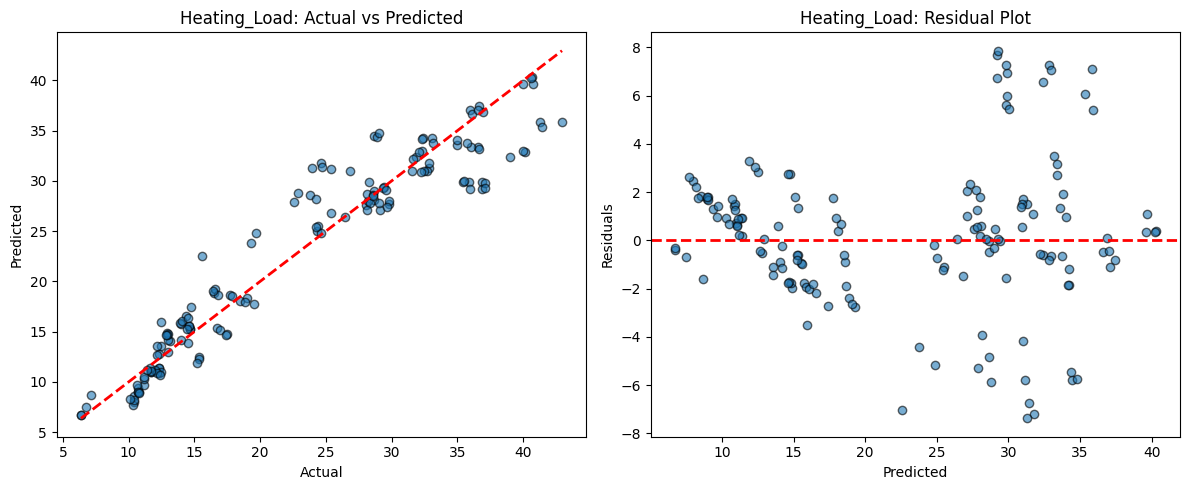



Multi-output Linear Regression for Cooling_Load:
MSE=9.893, RMSE=3.145, R2=0.893




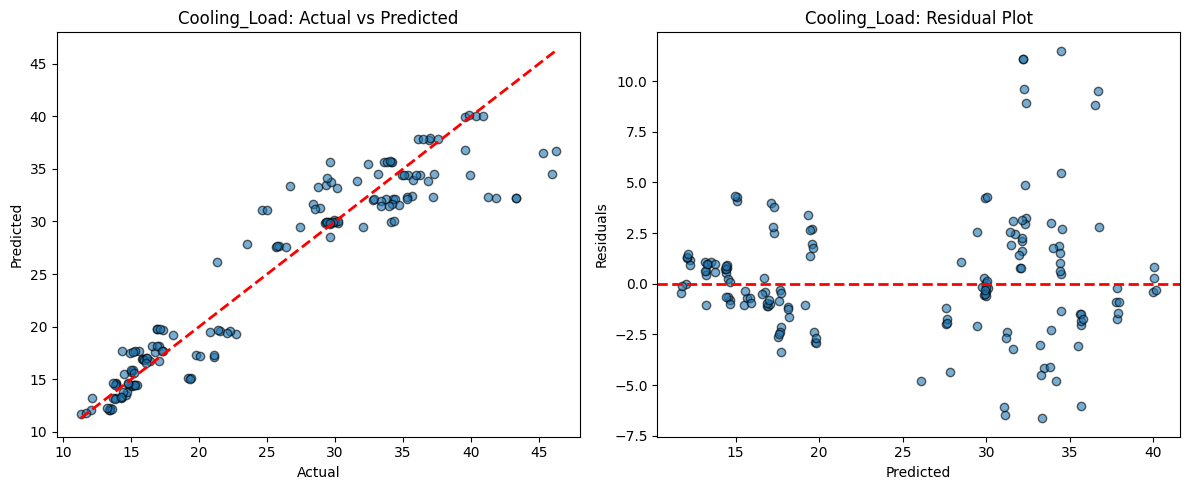

In [21]:
# multi-output regression with linear regression
multi_lr = LinearRegression()
multi_target_model = MultiOutputRegressor(multi_lr)

multi_target_model.fit(X_train, y_train[['Heating_Load', 'Cooling_Load']])
y_pred_multi = multi_target_model.predict(X_test)

# Evaluate both outputs
for i, target in enumerate(['Heating_Load', 'Cooling_Load']):
    mse = mean_squared_error(y_test[target], y_pred_multi[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[target], y_pred_multi[:, i])
    
    print(f"Multi-output Linear Regression for {target}:")
    print(f"MSE={mse:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    print("\n")
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Extract predictions for the current target
    y_pred_target = y_pred_multi[:, i]
    
    # Scatterplot: Actual vs Predicted
    axes[0].scatter(y_test[target], y_pred_target, alpha=0.6, edgecolors="k")
    axes[0].plot([y_test[target].min(), y_test[target].max()],
                 [y_test[target].min(), y_test[target].max()], 'r--', lw=2)
                 
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{target}: Actual vs Predicted")
    
    # Residual Plot
    residuals = y_test[target] - y_pred_target
    axes[1].scatter(y_pred_target, residuals, alpha=0.6, edgecolors="k")
    axes[1].axhline(y=0, color="r", linestyle="--", lw=2)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title(f"{target}: Residual Plot")
    
    plt.tight_layout()
    plt.show()
    print("\n")

# Final Insights

The identical results lead to several significant insights regarding the nature of the data and the modeling approach:

1. Individual linear models still prove to be sufficient:

    The lack of a performance difference between the multi-output and individual models indicates that, for this dataset, a simpler, single-output approach is entirely sufficient. The multi-output linear regression model did not gain any predictive advantage by considering the two output variables jointly. This suggests that the relationship between the input features and each output is independent of the other output.

2. Model limitations in exploiting interdependencies: 

    The findings highlight a fundamental limitation of the chosen model. Even if a statistical correlation exists between 'Heating Load' and 'Cooling Load', a common observation in building efficiency data, the linear regression model's architecture is incapable of utilizing this information to enhance its predictions. The model's predictions for each target are made independently, based solely on its relationship with the input features.

3. Computational efficiency and model parsimony: 

    Given the identical performance, the individual linear regression models are the preferred choice here. They adhere to the principle of parsimony, favoring the simplest model that explains the data well. Additionally, managing two separate, easily interpretable models is often more straightforward than a multi-output setup, especially since there is no significant computational advantage to be gained from combining them in this case.

4. Implications for future work: 

    This analysis confirms that to explore potential performance gains from inter-target dependencies, a more sophisticated model is required. Future work should investigate more advanced multi-output regression techniques, such as a neural network, which are architecturally designed to capture and leverage such complex relationships.